In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.transform import Rotation as R
%matplotlib inline

import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

# Functions

In [2]:
def aligment_rotation(reference, not_reference):
    
    ref = mda.Universe(reference)
    mobile = mda.Universe(not_reference)
    
    ref0 = ref.select_atoms('name CA').positions - ref.atoms.center_of_mass()
    mobile0 = mobile.select_atoms('name CA').positions - mobile.atoms.center_of_mass()
    mobile_all = mobile.select_atoms('all').positions - mobile.atoms.center_of_mass()
    
    Ra, rmsd = align.rotation_matrix(mobile0, ref0)
    mobile_rotated=np.dot(Ra, mobile_all.T)
    
    return (Ra, mobile_rotated)

def aligment_rotation_coord(reference, not_reference):
    
    Ra, mobile_rotated = aligment_rotation(reference, not_reference)
    
    mobile_rot_x=mobile_rotated[0]
    mobile_rot_y=mobile_rotated[1]
    mobile_rot_z=mobile_rotated[2]
    
    return (mobile_rot_x, mobile_rot_y, mobile_rot_z)

def quaternion_rotation(q, x, y, z):
    
    Q = R.from_quat(q).as_matrix()
    
    coord = np.array([x,y,z])
    rot_coord = np.dot(Q, coord)
    
    x_rot = rot_coord[0]
    y_rot = rot_coord[1]
    z_rot = rot_coord[2]
    
    return(x_rot, y_rot, z_rot)

def i_sel (x,xi,sigma,n):
    
    return (i for i in range(len(x)) if abs(x[i]-xi)<=n*sigma)

def I_calculated_A (x_atom, y_atom, sigma, n, res):
    
    x = np.linspace(min(x_atom)-1,max(x_atom)+1, res)
    y = np.linspace(min(y_atom)-1,max(y_atom)+1, res)
    
    Ixy = 0
    Ax=[]
    Ay=[]
    
    for atom in range(len(x_atom)):
        
        X = np.zeros(len(x))
        Y = np.zeros(len(x))
        
        i_x_selected=list(i_sel (x,x_atom[atom],sigma,n))
        i_y_selected=list(i_sel (y,y_atom[atom],sigma,n))
        
        X[i_x_selected]=np.exp(-0.5*(((x[i_x_selected]-x_atom[atom])/sigma)**2))
        Y[i_y_selected]=np.exp(-0.5*(((y[i_y_selected]-y_atom[atom])/sigma)**2))
                
        Ixy += np.matmul(X.reshape(len(x),1), Y.reshape(1,len(y)))
        
        Ax_atom=np.matmul((((x-x_atom[atom])/sigma**2)*X).reshape(len(x),1),Y.reshape(1,len(Y)))
        Ay_atom=np.matmul(X.reshape(len(x),1),(((y-y_atom[atom])/sigma**2)*Y).reshape(1,len(Y)))
        Ax.append(Ax_atom)
        Ay.append(Ay_atom)
        
    Ax=np.array(Ax)
    Ay=np.array(Ay)
    a=(1/(2*np.pi*sigma**2*len(x_atom)))
    
    return(a*Ixy, Ax, Ay)

def g2ce(Ic, Ir):
    
    s=-np.trace(np.dot(Ic, Ir.T))
    Ic_expval=np.sum(Ic)
    Ir_expval=np.sum(Ir)
    
    return(s/(Ic_expval*Ir_expval)) 

def grad_g2ce(Ic, Ir, Ax, Ay, N_atoms):
    
    s=-np.trace(np.dot(Ic, Ir.T))
    Ic_expval=np.sum(Ic)
    Ir_expval=np.sum(Ir)
    
    g2 = s/(Ic_expval*Ir_expval)
    
    Ic_dx=[]
    Ic_dy=[]
    s_dx=[]
    s_dy=[]
    a=(1/(2*np.pi*sigma**2*N_atoms))
    
    for i in range(N_atoms):
        Ic_dxi=a*np.sum(Ax[i])
        Ic_dyi=a*np.sum(Ay[i])
        s_dxi=-a*np.trace(np.matmul(Ax[i],Ir.T))
        s_dyi=-a*np.trace(np.matmul(Ay[i],Ir.T))
        
        Ic_dx.append(Ic_dxi)
        Ic_dy.append(Ic_dyi)
        s_dx.append(s_dxi)
        s_dy.append(s_dyi)
        
    Ic_dx=np.array(Ic_dx)
    Ic_dy=np.array(Ic_dy)
    s_dx=np.array(s_dx)
    s_dy=np.array(s_dy)

    grad_x=g2*((s_dx/s)-(Ic_dx/Ic_expval))
    grad_y=g2*((s_dy/s)-(Ic_dy/Ic_expval))
    
    grad=np.array([grad_x,grad_y])

    return(grad)

def gradient_descent_g2(Ic, Ir, x_c, y_c, Axc, Ayc, sigma, n, res, k, N):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)
    
    for i in tqdm(range(N)):
        x_gd = x_gd - k*grad_x
        y_gd = y_gd - k*grad_y
        Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
        grad_x, grad_y = grad_g2ce(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms)
    
    g2 = g2ce(Ic_gd, Ir)
    grad_gd = grad_x, grad_y
    
    return (g2, grad_gd, Ic_gd)

def gradient_descent_g2_anh(Ic, Ir, x_c, y_c, Axc, Ayc, sigma0, sigmaf, n, res, k, N):
    
    N_atoms=len(x_c)
    x_gd=x_c
    y_gd=y_c
    grad_x, grad_y = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)
    
    for i in tqdm(range(N)):
        x_gd = x_gd - k*grad_x
        y_gd = y_gd - k*grad_y
        sigma =-((sigma0-sigmaf)/(N-1))*i + sigma0
        Ic_gd, Axc_gd, Ayc_gd = I_calculated_A (x_gd, y_gd, sigma, n, res)
        grad_x, grad_y = grad_g2ce(Ic_gd, Ir, Axc_gd, Ayc_gd, N_atoms)
    
    g2 = g2ce(Ic_gd, Ir)
    grad_gd = grad_x, grad_y
    
    return (g2, grad_gd, Ic_gd)

# Aligment, Rotation and Projection

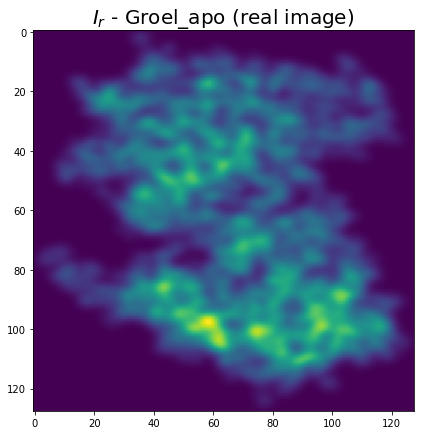

In [7]:
reference='groel_frame_13120.pdb'
not_reference='groel_apo.pdb'

q=[0,0,1/np.sqrt(2),1/np.sqrt(2)] #Quaternion parameters

n=3      #Sigma times
sigma=1  #Standar deviation of the Gaussians
res=128  #Grid's resolution

x_r, y_r, z_r = aligment_rotation_coord(reference, not_reference)

x_r, y_r, z_r = quaternion_rotation(q, x_r, y_r, z_r)

Ir, Axr, Ayr = I_calculated_A (x_r, y_r, sigma, n, res)

plt.imshow(Ir)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_r$ - Groel_apo (real image) ', fontsize=20)
plt.show()

# Atomic Coordinates for the Calculated Image

In [4]:
#Coordintes for calculated image 
N_atoms=len(x_r)
g=1

x_noise=np.random.normal(0, g, x_r.shape)
y_noise=np.random.normal(0, g, y_r.shape)

x_c=x_r+x_noise
y_c=y_r+y_noise

#x_c=np.max(x_r)*(2*np.random.random(N_atoms)-1)
#y_c=np.max(y_r)*(2*np.random.random(N_atoms)-1)

# Calculated image with anheeling, CV and Gradient

g2 = -0.00010316119388972747

grad_g2_x = [-2.20876898e-08 -1.78090069e-08 -2.71797685e-08 ...  2.53098378e-08
  1.18614677e-08  2.17866477e-08]

grad_g2_y = [-3.65394943e-08 -3.61165559e-08 -3.75095961e-08 ... -5.02942832e-08
 -3.89412784e-08 -4.09679908e-08]


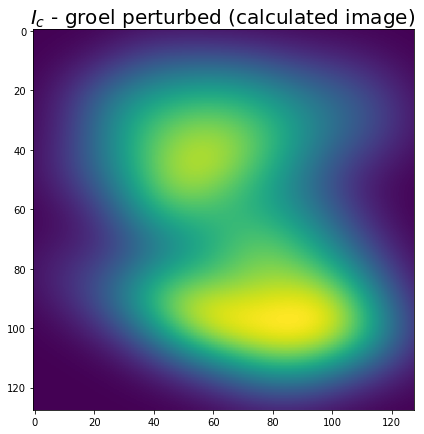

In [5]:
sigma0=6
Ic, Axc, Ayc = I_calculated_A (x_c, y_c, sigma0, n, res)

g2 = g2ce(Ic, Ir)
grad_g2 = grad_g2ce(Ic, Ir, Axc, Ayc, N_atoms)

print('g2 = {}\n'.format(g2))
print('grad_g2_x = {}\n'.format(grad_g2[0]))
print('grad_g2_y = {}'.format(grad_g2[1]))

plt.imshow(Ic)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_c$ - groel perturbed (calculated image) ', fontsize=20)
plt.show()

# Gradient Descent with decreasing $\sigma$

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:50<00:00,  5.50s/it]


g2_old= -0.00010316119388972747
g2_new= -0.0001317269107693338


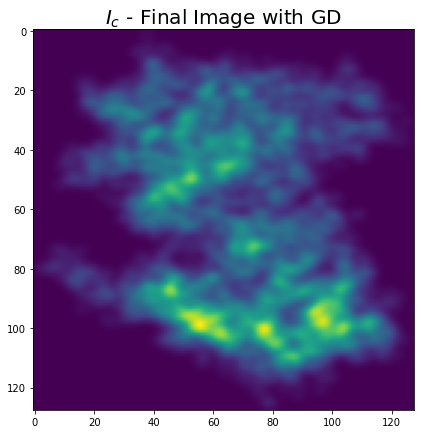

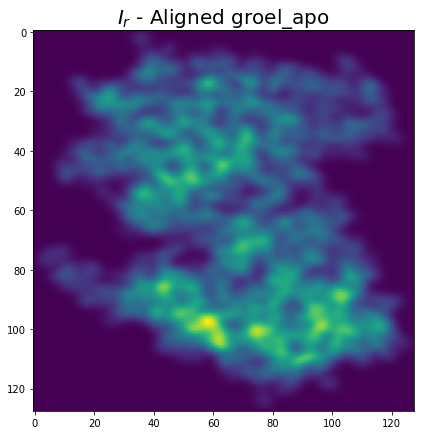

In [6]:
k=10e5 #Learning Rate
N=20   #Gradient Descent Steps
sigmaf=sigma
g2_gd, grad_gd, Ic_gd = gradient_descent_g2_anh(Ic, Ir, x_c, y_c, Axc, Ayc, sigma0, sigmaf, n, res, k, N)

print('g2_old=',g2)
print('g2_new=',g2_gd)
plt.imshow(Ic_gd)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_c$ - Final Image with GD ', fontsize=20)
plt.show()

plt.imshow(Ir)
plt.rcParams["figure.figsize"] = (7,7)
plt.title(r'$I_r$ - Aligned groel_apo ', fontsize=20)
plt.show()